In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import warnings 
warnings.filterwarnings('ignore')

from imblearn.combine import SMOTEENN

from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_validate

from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,ExtraTreesClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score,auc,make_scorer,roc_curve, confusion_matrix,classification_report, roc_auc_score,f1_score

from itertools import cycle,product

from boruta import BorutaPy

In [2]:
# Reading approved data
df_raw_app = pd.read_csv('APPROVED_DATA_JAN2020.csv',encoding='mac_roman',index_col = 0)
df_raw_app.shape

(280058, 32)

In [3]:
df_raw_app.columns

Index(['customer_id', 'loan_request_id', 'interest_rate', 'loan_amount',
       'loan_transferred_date', 'def_flag', 'total_due_amount', 'age',
       'monthly_salary', 'education_type_id', 'address_rank', 'house_type_id',
       'address_type_id', 'creation_duration', 'purpose_cashe',
       'referral_status', 'referrer_status', 'googleplus_status',
       'facebook_status', 'linkedin_status', 'designation_id',
       'noOfConnections', 'noOfApps', 'noOfCallLog', 'noOfSMS', 'OS',
       'noOfContacts', 'os_version', 'operator_name', 'last_payment_date',
       'monthly_customer_income', 'salary_day'],
      dtype='object')

In [4]:
# Reading approved data
df_app_cibil= pd.read_csv('cibil_score-1.csv',index_col = 0)
df_app_cibil.shape

(310800, 5)

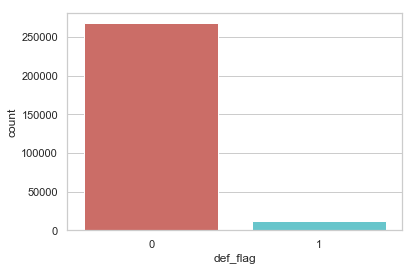

In [5]:
sns.countplot(x='def_flag',data=df_raw_app, palette='hls')
plt.show()

In [6]:
# Reading rejected data
df_raw_rej = pd.read_csv('New Data_rejected_Oct2019.csv',encoding='utf-8',index_col=0)
df_raw_rej.shape

(49984, 27)

In [7]:
# Reading CIBIL scores
df_rej_cibil = pd.read_excel('Cibil.xlsx') 

# Prediction

## ML settings and functions

In [8]:
#set colors and line styles for later ploting use
colors = ['aqua', 'darkorange', 'cornflowerblue',"navy", "deeppink","grey","green","lightcoral", "yellowgreen","purple","pink","moccasin","indigo","firebrick"]
linestyles = ['-', '--', '-.',':']
combine = list(product(colors, linestyles))


# set machine labels and models used later
ml_labels = ["LR_l2",
             "RF",
             "GB",
             "XGB",
            ]

models = [LogisticRegression(penalty= 'l2',solver = 'saga'),
          RandomForestClassifier(),
          GradientBoostingClassifier(),
          XGBClassifier()
         ]


In [9]:
def model_predict(model,features_train,features_test,labels_train,labels_test):
    '''
    Make prediction on machine learning
    
    input:  model -- the model used to predict
            features_train -- the training data(x_train)
            features_test -- the testing data(x_test)
            labels_train -- the training labels(y_train)
            labels_test -- the testing labels(y_test)
            
    return: the predicted values and probabilities
    '''
    
    model.fit(features_train,labels_train.ravel())
    
    pred=model.predict(features_test)
    prob = model.predict_proba(features_test)
    
    #print(classification_report(labels_test,pred))
    return pred,prob

In [10]:
def roc_get_par(test,prob):
    '''
    get false positive and true positive score
    
    input:  test -- the true values
            prob -- predicted probilities
            
    return: a FP and TP rate list
    '''
    
    fpr, tpr, _  = roc_curve(test, prob[:,1])
    return [ fpr, tpr] 

In [11]:
def balancing(x,y,target):
    '''
    balance the data
    
    input:  x -- the x values(dataframe)
            y -- the y values
            target -- the name of the target
            
    return: balanced dataframe
    '''
    
    x_new, Y_new = SMOTEENN().fit_sample(x,y)
    
    x_new = pd.DataFrame(x_new,columns = x.columns.tolist() )
    Y_new = pd.DataFrame(Y_new,columns =target )
    df = pd.concat([x_new,Y_new],axis = 1)
    return df

In [12]:
def df_info(df,target):
    '''
    print out the information of the input dataframe, including a plot of target values and descriptions
    
    input:  df -- the dataframe to print out
            target -- the target name
            
    return: NA
    '''
    print('\n')
    sns.countplot(x=target,data=df, palette='hls')
    plt.show()
    
    print("There are {} records in the dataset ".format(df.shape[0]))
    print("There are {} records make {} 1 in the dataset ".format(df[df[target] == 1].shape[0],target))
    print("There are {} records make {} 0 in the dataset ".format(df[df[target] == 0].shape[0],target))

In [13]:
def training(traning,testing,target,var_group,combine_var,models = models):
    '''
    print out the information of the input dataframe, including a plot of target values and descriptions
    
    input:  training -- the training data
            testing -- the testing data
            target -- the name of the target
            var_group -- the names of feature groups (list)
            combine_var -- the names of feature groups and ml models(list)
            models -- models to use in the training
            
    return: the result of prediction and the pars for ROC curve
    '''
    par = []
    acc_v = []
    acc_t = []
    au_v = []
    au_t = []
    
    
    for model in models:
        for var in var_group:

            cv = cross_validate(model, 
                                traning.loc[:,var], 
                                traning[target], 
                                cv=5,
                                scoring=('accuracy', 'roc_auc'),
                                return_train_score=True)

            acc_v.append(cv['test_accuracy'].mean())
            au_v.append(cv['test_roc_auc'].mean())

            pred,prob = model_predict(model,
                                      traning.loc[:,var],
                                      testing.loc[:,var],
                                      traning[target],
                                      testing[target])        

            r= roc_get_par(testing[target],prob)

            au_t.append(auc(r[0],r[1]))
            acc_t.append(accuracy_score(testing[target],pred))
            par.append(r)

        print('--------------------------')
    result_df = {'variable_model': combine_var,
                 'cross_v_accuracy':acc_v,
                 'test_accuracy':acc_t,
                 'cross_v_auc':au_v,
                 'test_auc':au_t
                }
    return pd.DataFrame(result_df), par


In [14]:
model_names = ["Logistic Regression",
               "Random Forest",
               "Gradient Boosting",
               "XgBoost",
              ]


def roc_plt(par, group_name ,model_names = model_names):
    '''
    plot the roc curve
    
    input:  par -- pars calculated from prediction
            group_name --  the names of feature groups 
            model_names -- the name of the models used
            
    return: NA
    '''
    l_var = list(product(model_names,group_name))
    
    for n in range(len(model_names)):
        
        plt.figure(figsize=(15, 10))
        plt.plot([0, 1], [0, 1], 'k--')
        
        for i in range(len(group_name)*n,len(group_name)*(n+1)):
            
            plt.plot(par[i][0], 
                     par[i][1], 
                     label=l_var[i][0] + ' + '+l_var[i][1],
                     color=combine[4*(i-len(group_name)*n)][0], 
                     linestyle=combine[4*(i -len(group_name)*n)][1])
            
        plt.xlabel('Specificity')
        plt.ylabel('Sensitivity')
        plt.title(model_names[n] + ' ROC curve')
        plt.legend(loc='best')
        plt.show()


In [15]:
def drop_all_f(par):
    '''
    drop prediction for all feature
    
    input:  par -- pars calculated from prediction
            
    return: list of pars without all features
    '''    
    return [par[n] for n in range(len(par)) if (n+1)%4 != 0]

## Data prepartion

In [16]:
def log(data):
    '''
    Calculate the log of a number
    
    input: a number
    output: log value of orginal number plus 1
    '''
    return np.log(data+1)

In [17]:
df_raw_app_cibil = pd.merge(left=df_raw_app,right=df_app_cibil, right_on='loan_request_id',left_on ='loan_request_id',suffixes = ['','_']).drop(['customer_id_'],axis = 1)
df_raw_rej_cibil = pd.merge(left=df_raw_rej,right=df_app_cibil, right_on='customer_id',left_on ='customer_id')

In [18]:
# select features needed. Then to drop na.
features = ['age','monthly_salary','education_type_id','loan_amount','designation_id','purpose_cashe',
            'noOfSMS','noOfContacts','noOfApps','noOfCallLog','linkedin_status','facebook_status','OS',
            'cibil_score'
           ] 

df_rej = df_raw_rej_cibil.loc[:,features]
df_app= df_raw_app_cibil.loc[:,features+['def_flag']]

# rename the variables in rejected data to make it the same as in the approved
col_rename = {'education_type_id':'edu',
              'designation_id':'desig',
             }

df_rej.rename(columns=col_rename, inplace=True)
df_app.rename(columns=col_rename, inplace=True)

In [19]:
#calculate log values of certain features needed
df_app['cibil_score'] = df_app['cibil_score'] +1
df_rej['cibil_score'] = df_rej['cibil_score'] +1

to_log=['age','loan_amount','monthly_salary','noOfApps','noOfCallLog','noOfContacts','noOfSMS','cibil_score',]
log_var = ['lage','log_loan','log_sal','lapps','lcallog','lcontact','lsms','lcibil',]

for i in range(len(to_log)):
    df_rej[log_var[i]] = log(df_rej[to_log[i]])
    df_app[log_var[i]] = log(df_app[to_log[i]])

In [20]:
df_rej.dropna(inplace = True)
df_app.dropna(inplace = True)

In [21]:
# make OS features present as numbers

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

df_rej["ios"] = encoder.fit_transform(df_rej.OS.astype(str))
df_app["ios"] = encoder.transform(df_app.OS.astype(str))

encoder.classes_

array(['Android', 'iOS'], dtype=object)

In [22]:
print("There are {} records in the approved set originally".format(df_raw_app.shape[0]))
print("There are {} records in the approved set after dropping Na".format(df_app.shape[0]))
print('\n')
print("There are {} records in the rejected set originally".format(df_raw_rej.shape[0]))
print("There are {} records in the rejected set after dropping Na".format(df_rej.shape[0]))

There are 280058 records in the approved set originally
There are 228830 records in the approved set after dropping Na


There are 49984 records in the rejected set originally
There are 34479 records in the rejected set after dropping Na


In [48]:
Digital_info = ['lsms','lcallog','lcontact','facebook_status','linkedin_status','lapps','ios']
Borrower_info = ['lage','log_sal']
Cibil = ['lcibil']

features_all = Digital_info+Borrower_info+Cibil

var_group = [Borrower_info,
             Digital_info,
             Cibil,
             Borrower_info + Cibil,
             Digital_info + Cibil,
             features_all
            ]


## Prediction for default

In [49]:
group_name = ['Customer characteristics',
              'Customer + Cibil',
             'Digital footprint',
               'Digital + Cibil',
          'Cibil score',
          'Digital + Cibil + Customer'
         ]
combine_var = list(product(ml_labels,group_name))

In [50]:
df_app_def = df_app

#### All data

In [51]:
df_app_def_train, df_app_def_test  = train_test_split(df_app_def,test_size=0.3)
df_app_def.shape

(228830, 24)

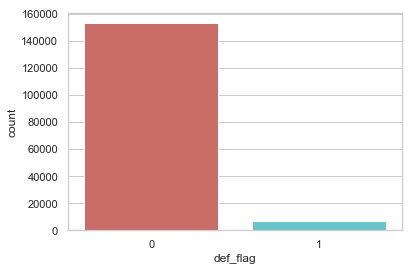

There are 160181 records in the dataset 
There are 7076 records make def_flag 1 in the dataset 
There are 153105 records make def_flag 0 in the dataset 




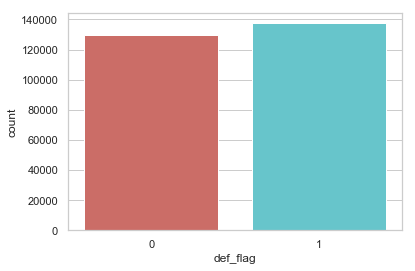

There are 267040 records in the dataset 
There are 137483 records make def_flag 1 in the dataset 
There are 129557 records make def_flag 0 in the dataset 


In [52]:
df_info(df_app_def_train,'def_flag')
df_app_def_train_all = balancing(df_app_def_train.loc[:,features_all], df_app_def_train.loc[:,'def_flag'],['def_flag'])
df_info(df_app_def_train_all,'def_flag')

In [39]:
result_def_all , par_def_all = training(df_app_def_train_all,
                                        df_app_def_test,
                                        'def_flag',
                                        var_group,
                                        combine_var)

--------------------------
--------------------------
--------------------------
--------------------------


In [40]:
result_def_all.sort_values('test_auc',ascending = False)

,variable_model,cross_v_accuracy,test_accuracy,cross_v_auc,test_auc
11,"(RF, Digital + Cibil + Customer)",0.966188,0.880712,0.994696,0.717828
9,"(RF, Digital + Cibil)",0.957573,0.875643,0.992472,0.713117
8,"(RF, Digital footprint)",0.959909,0.864412,0.992558,0.699301
7,"(RF, Customer + Cibil)",0.894490,0.856720,0.963184,0.690515
6,"(RF, Customer characteristics)",0.906834,0.854827,0.964437,0.658994
5,"(LR_l2, Digital + Cibil + Customer)",0.592478,0.551734,0.635827,0.627775
17,"(GB, Digital + Cibil + Customer)",0.731523,0.657533,0.815640,0.623166
21,"(XGB, Digital + Cibil)",0.708621,0.652318,0.791718,0.623075
2,"(LR_l2, Digital footprint)",0.589100,0.546286,0.631849,0.623058
3,"(LR_l2, Digital + Cibil)",0.589014,0.546607,0.631769,0.623040


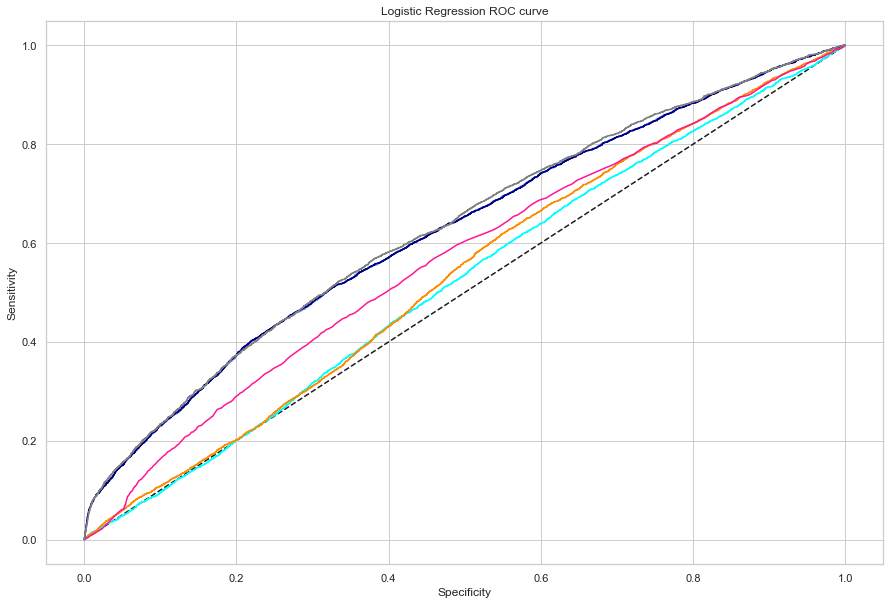

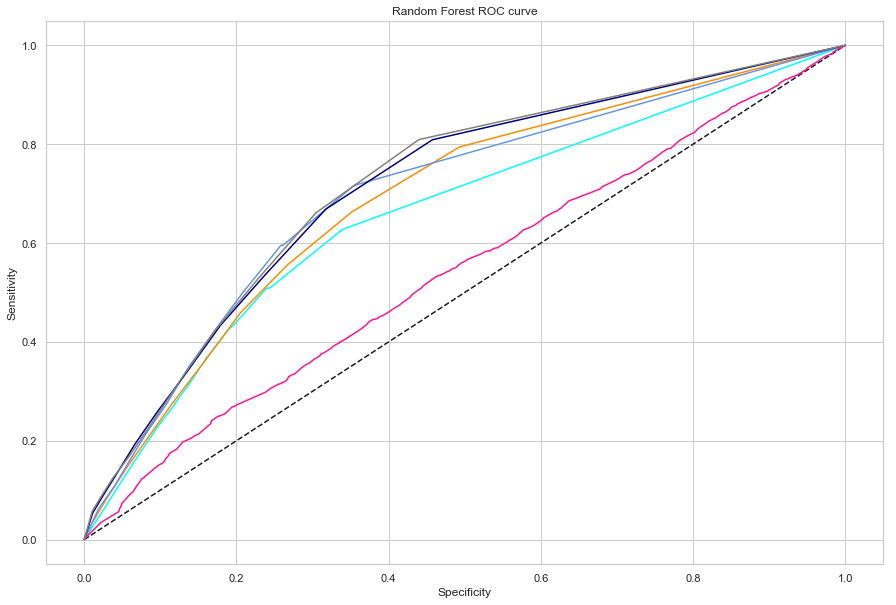

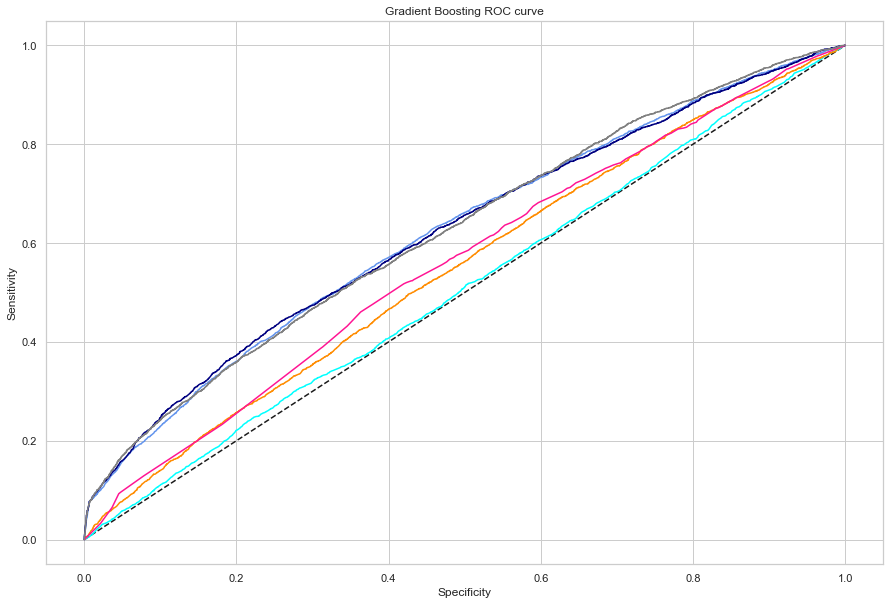

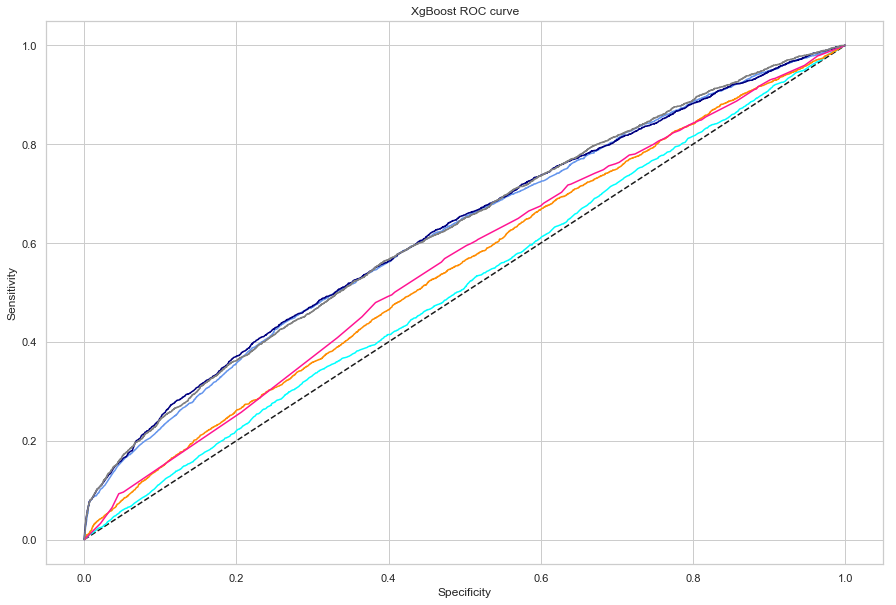

In [41]:
roc_plt(par_def_all, group_name)

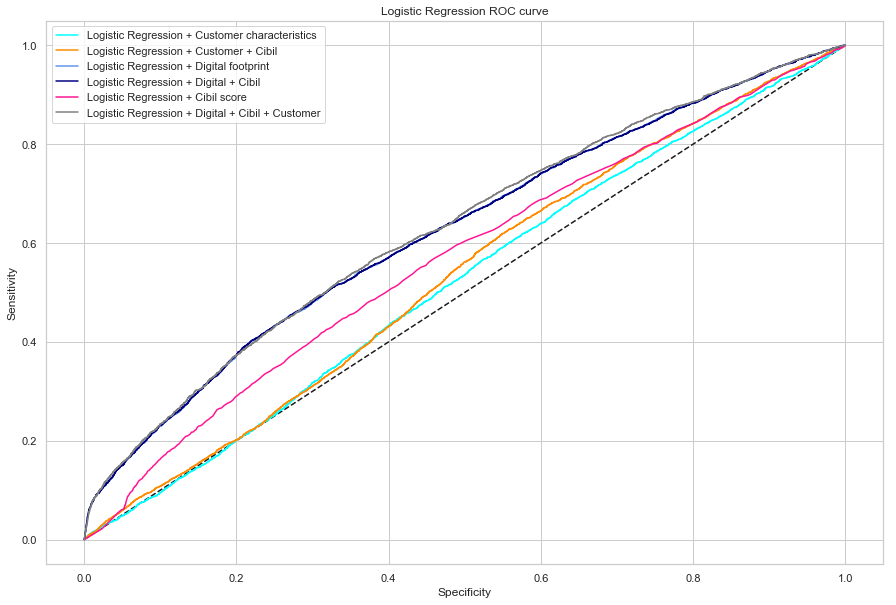

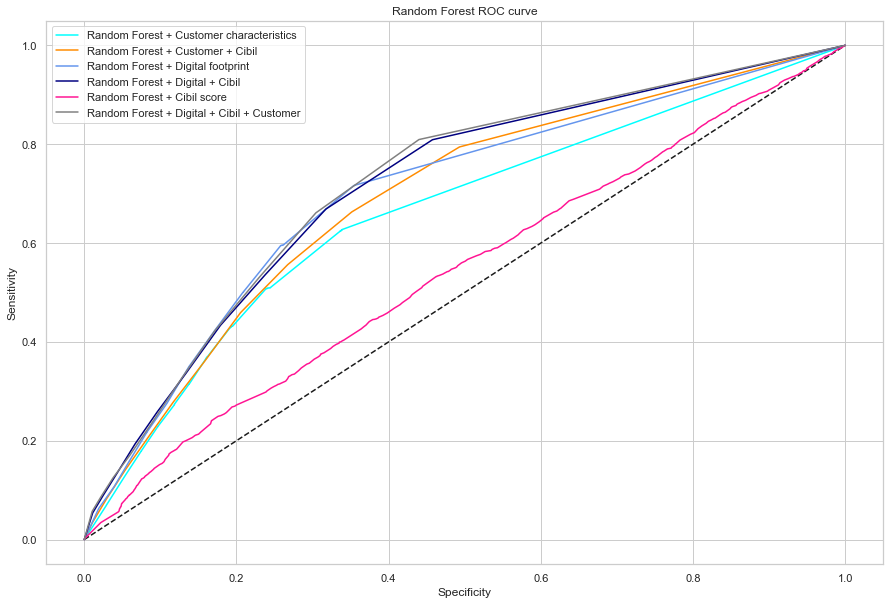

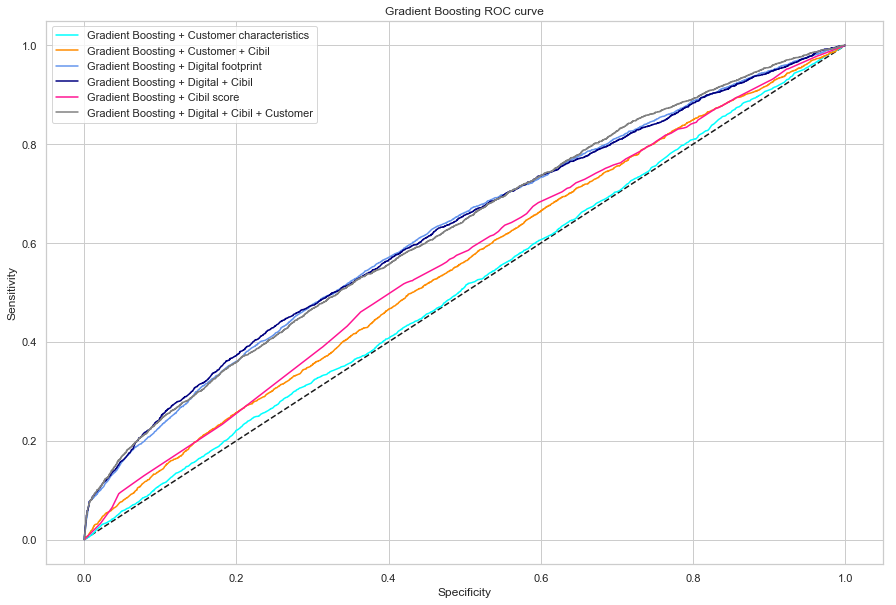

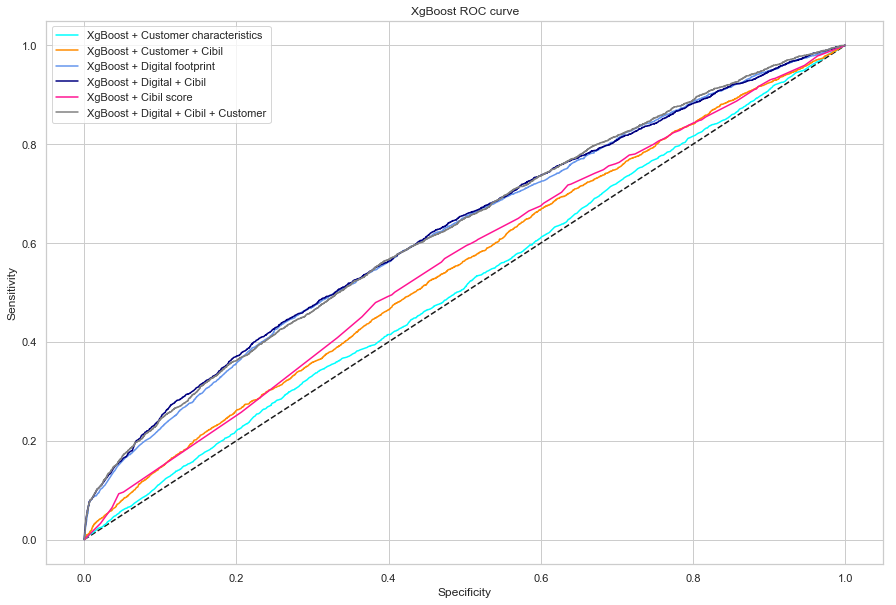

In [134]:
roc_plt(par_def_all, group_name)

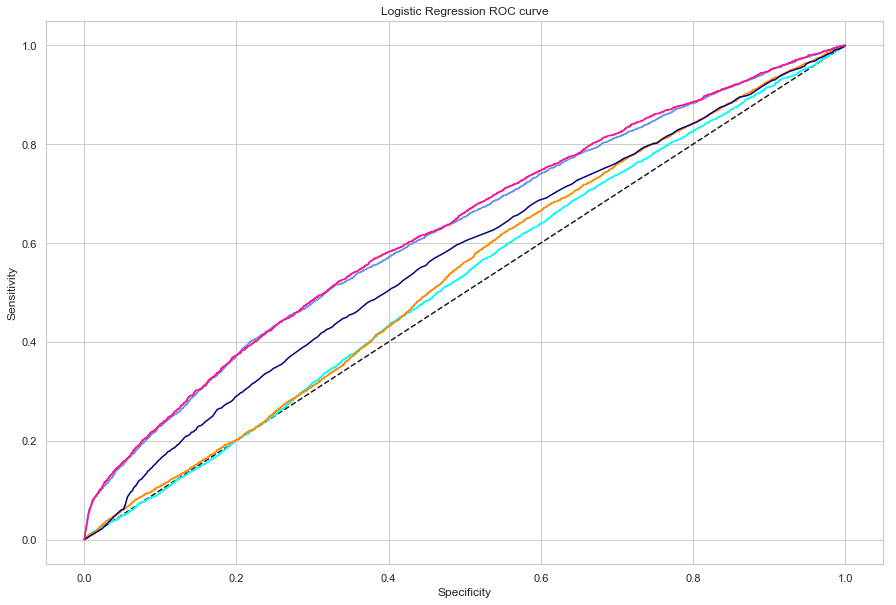

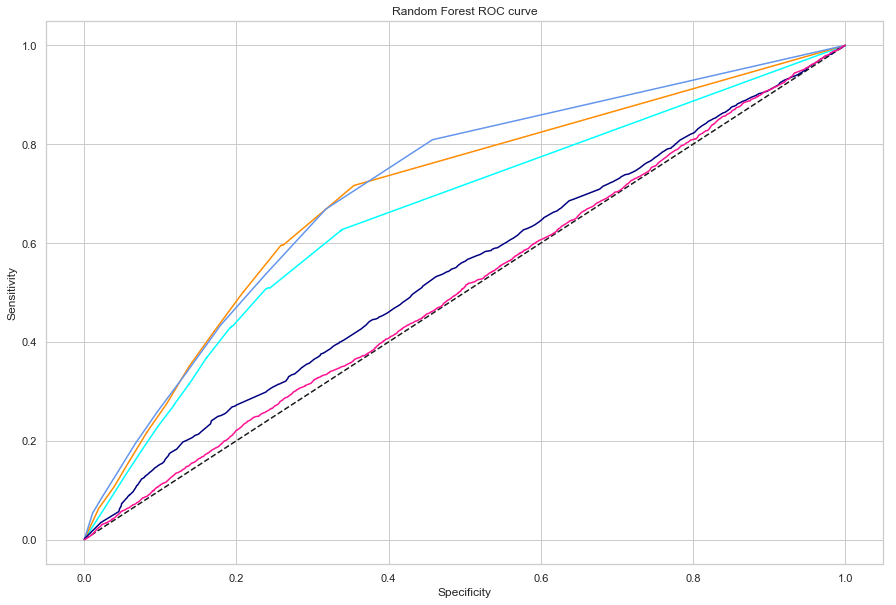

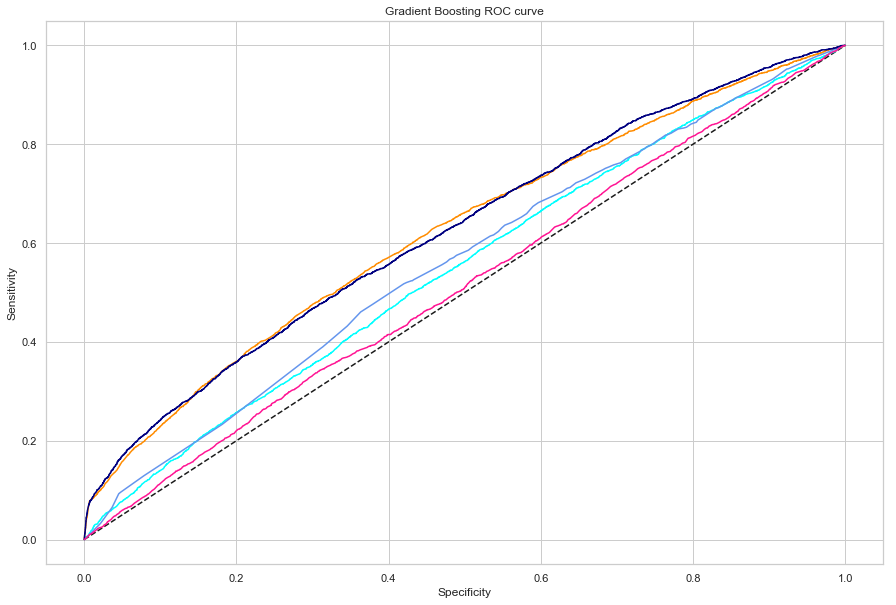

IndexError: list index out of range

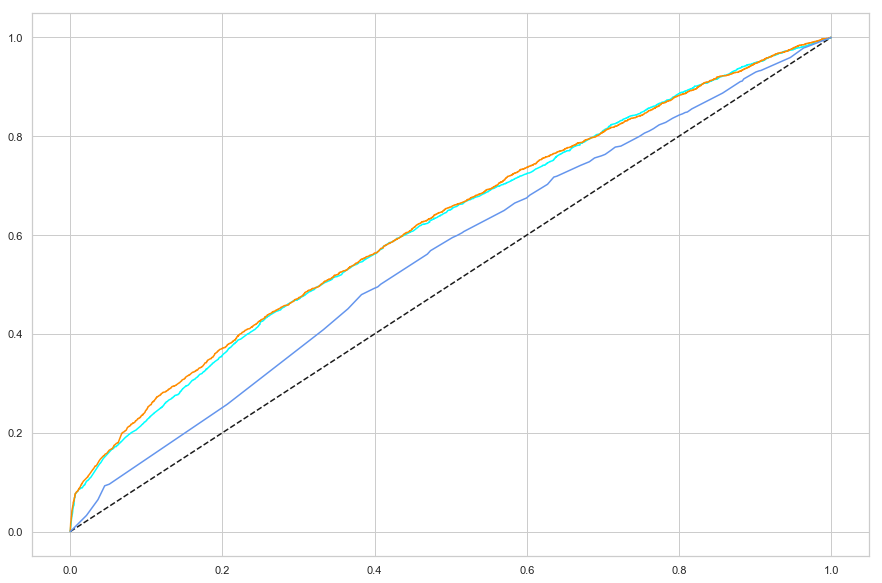

In [43]:
roc_plt(drop_all_f(par_def_all), group_name[:-1])

In [ ]:
#roc_plt(drop_all_f(par_def_all), group_name[:-1])

#### Cibil more than 750

In [44]:
df_app_def_750 = df_app_def[df_app_def.lcibil > log(750+1)]
df_app_def_750.shape

(7854, 24)

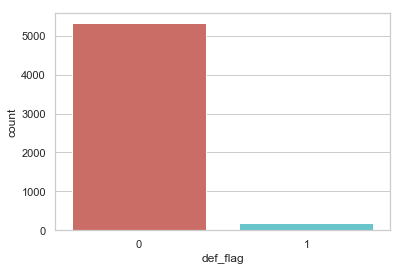

There are 5497 records in the dataset 
There are 177 records make def_flag 1 in the dataset 
There are 5320 records make def_flag 0 in the dataset 




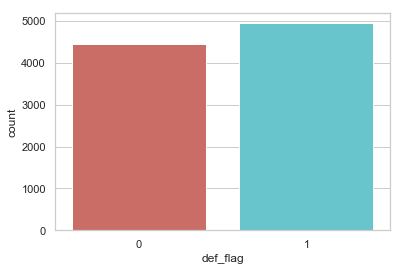

There are 9391 records in the dataset 
There are 4946 records make def_flag 1 in the dataset 
There are 4445 records make def_flag 0 in the dataset 


In [45]:
df_app_def_750_train, df_app_def_750_test  = train_test_split(df_app_def_750,test_size=0.3)
df_info(df_app_def_750_train,'def_flag')

df_app_def_train_750 = balancing(df_app_def_750_train.loc[:,features_all], 
                                 df_app_def_750_train.loc[:,'def_flag'],
                                 ['def_flag'])
df_info(df_app_def_train_750,'def_flag')

In [46]:
result_def_750 , par_def_750 = training(df_app_def_train_750,
                                        df_app_def_750_test,
                                        'def_flag',
                                        var_group,
                                        combine_var)

--------------------------
--------------------------
--------------------------
--------------------------


In [47]:
result_def_750.sort_values('test_auc',ascending = False)

,variable_model,cross_v_accuracy,test_accuracy,cross_v_auc,test_auc
8,"(RF, Digital footprint)",0.965393,0.894782,0.994225,0.685495
11,"(RF, Digital + Cibil + Customer)",0.974232,0.912176,0.996299,0.670885
6,"(RF, Customer characteristics)",0.862849,0.819262,0.936128,0.664681
7,"(RF, Customer + Cibil)",0.905124,0.868477,0.967402,0.648449
9,"(RF, Digital + Cibil)",0.972634,0.905388,0.995492,0.648361
3,"(LR_l2, Digital + Cibil)",0.583005,0.485787,0.608548,0.624971
2,"(LR_l2, Digital footprint)",0.580343,0.484514,0.606836,0.624405
5,"(LR_l2, Digital + Cibil + Customer)",0.577041,0.480272,0.613127,0.614298
14,"(GB, Digital footprint)",0.794061,0.705134,0.896183,0.613054
20,"(XGB, Digital footprint)",0.783198,0.681799,0.884000,0.596490


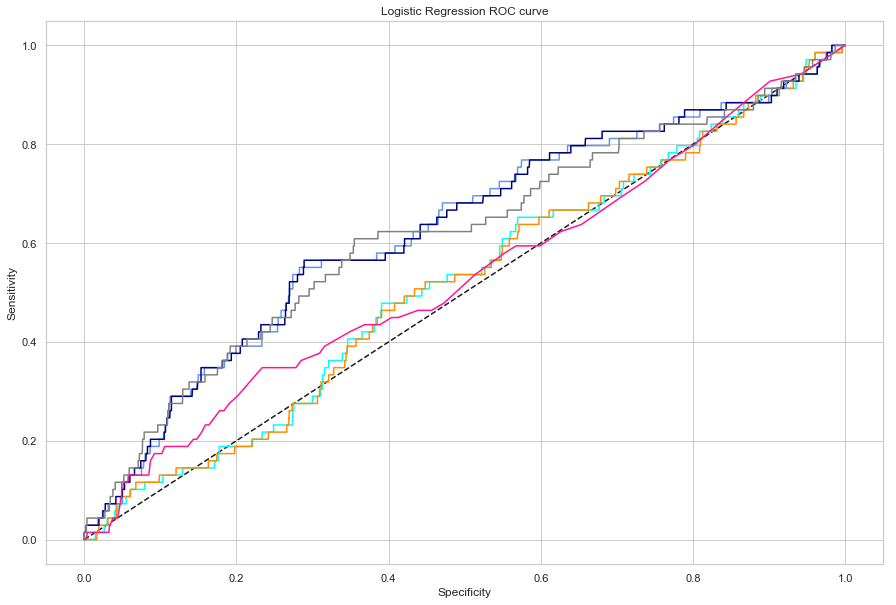

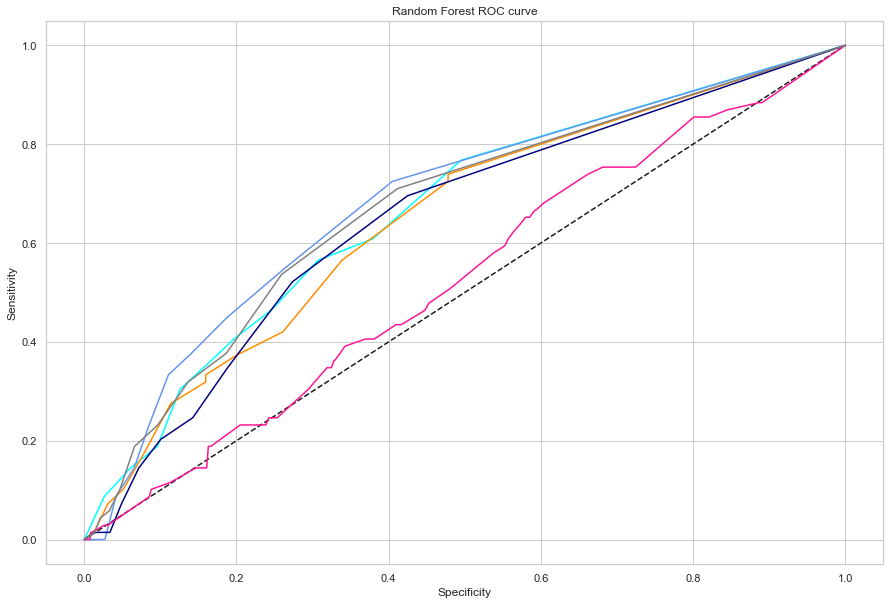

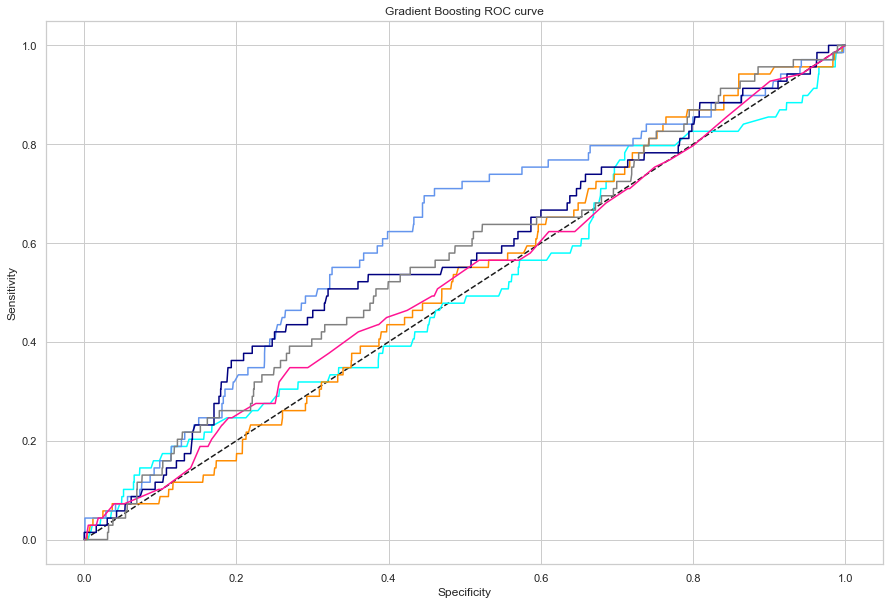

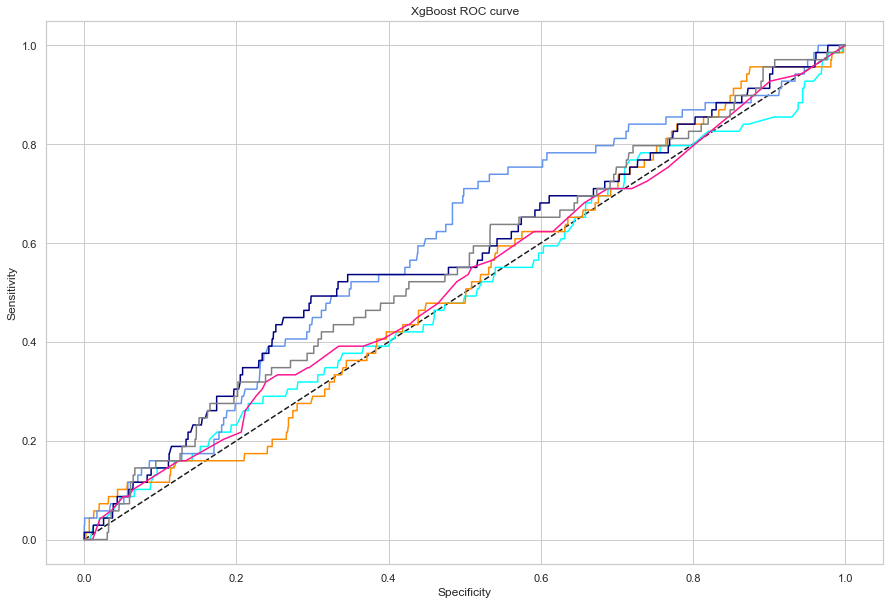

In [48]:
roc_plt(par_def_750, group_name)

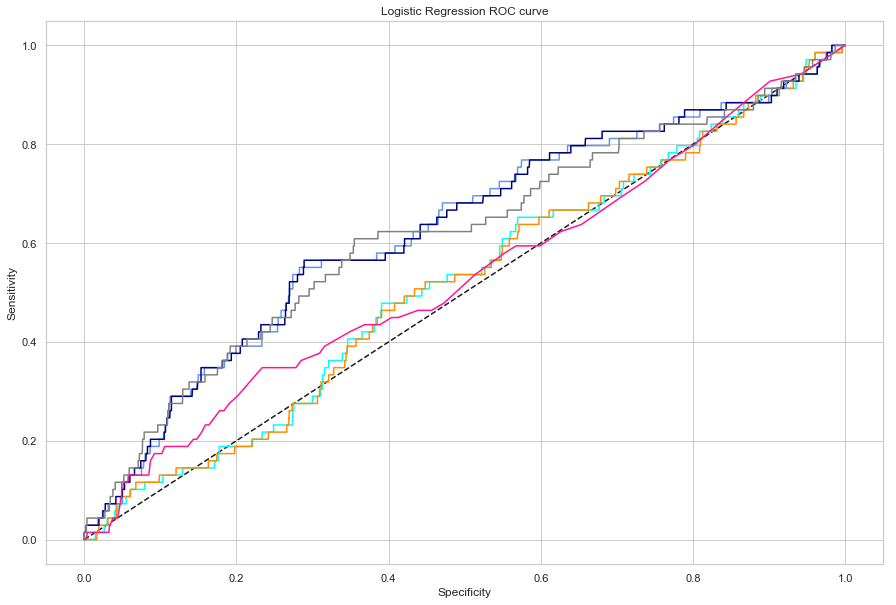

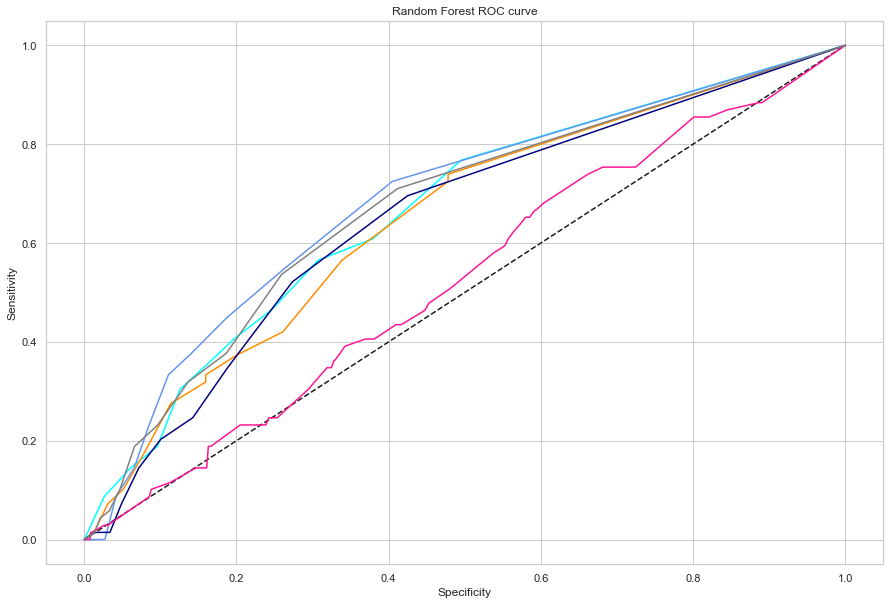

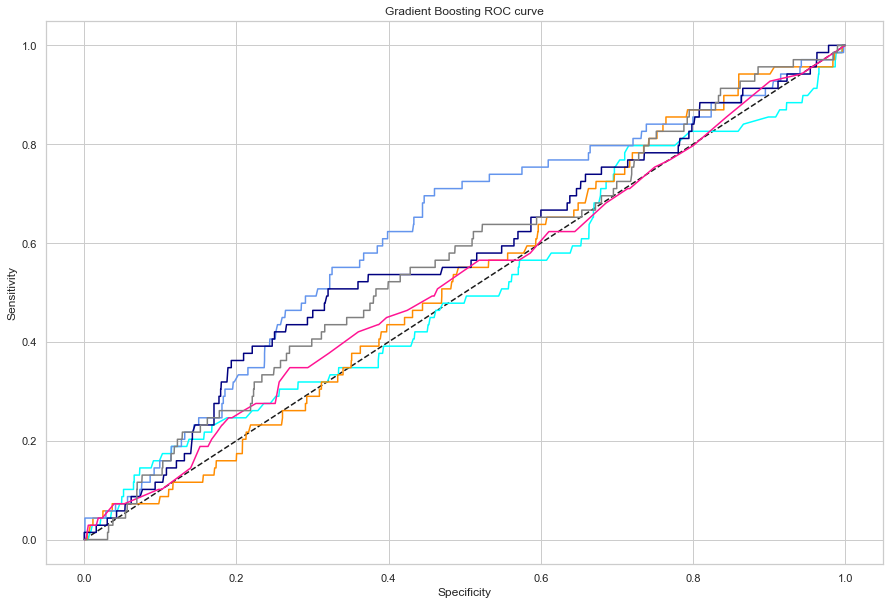

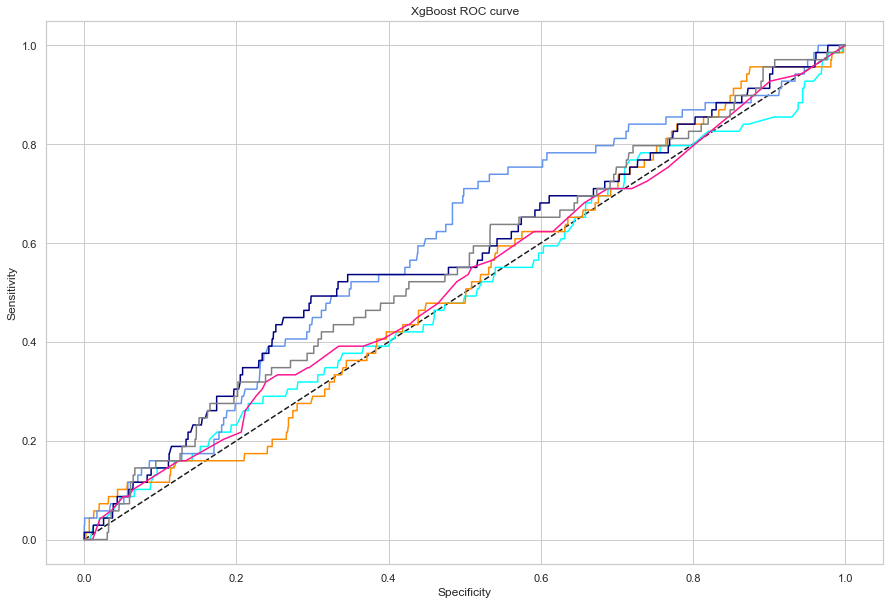

In [49]:
roc_plt(par_def_750, group_name)

In [1]:
#roc_plt(drop_all_f(par_def_750), group_name[:-1])

#### Cibil less than 350

In [51]:
df_app_def_350 = df_app_def[df_app_def.lcibil <= log(350+1)]
df_app_def_350.shape

(11844, 24)

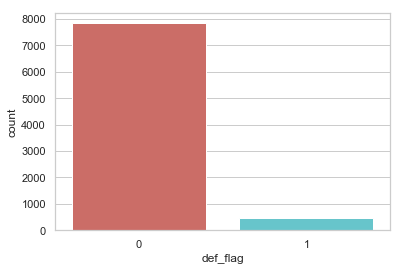

There are 8290 records in the dataset 
There are 452 records make def_flag 1 in the dataset 
There are 7838 records make def_flag 0 in the dataset 




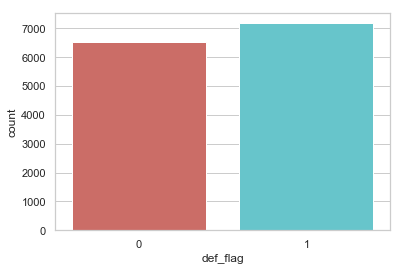

There are 13710 records in the dataset 
There are 7179 records make def_flag 1 in the dataset 
There are 6531 records make def_flag 0 in the dataset 


In [52]:
df_app_def_350_train, df_app_def_350_test  = train_test_split(df_app_def_350,test_size=0.3)
df_info(df_app_def_350_train,'def_flag')

df_app_def_train_350 = balancing(df_app_def_350_train.loc[:,features_all], 
                                 df_app_def_350_train.loc[:,'def_flag'],
                                 ['def_flag'])
df_info(df_app_def_train_350,'def_flag')

In [53]:
result_def_350 , par_def_350 = training(df_app_def_train_350,
                                        df_app_def_350_test,
                                        'def_flag',
                                        var_group,
                                        combine_var)

--------------------------
--------------------------
--------------------------
--------------------------


In [54]:
result_def_350.sort_values('test_auc',ascending = False)

,variable_model,cross_v_accuracy,test_accuracy,cross_v_auc,test_auc
9,"(RF, Digital + Cibil)",0.969732,0.882667,0.995679,0.801187
8,"(RF, Digital footprint)",0.958425,0.879291,0.992291,0.798759
11,"(RF, Digital + Cibil + Customer)",0.971553,0.879291,0.995948,0.794494
23,"(XGB, Digital + Cibil + Customer)",0.858572,0.811199,0.937202,0.783776
17,"(GB, Digital + Cibil + Customer)",0.864116,0.815701,0.941179,0.777404
21,"(XGB, Digital + Cibil)",0.837493,0.786719,0.925709,0.773563
15,"(GB, Digital + Cibil)",0.841286,0.790377,0.928668,0.772142
2,"(LR_l2, Digital footprint)",0.708024,0.693303,0.779214,0.768127
3,"(LR_l2, Digital + Cibil)",0.703283,0.690208,0.780677,0.768108
20,"(XGB, Digital footprint)",0.804014,0.744795,0.892766,0.764201


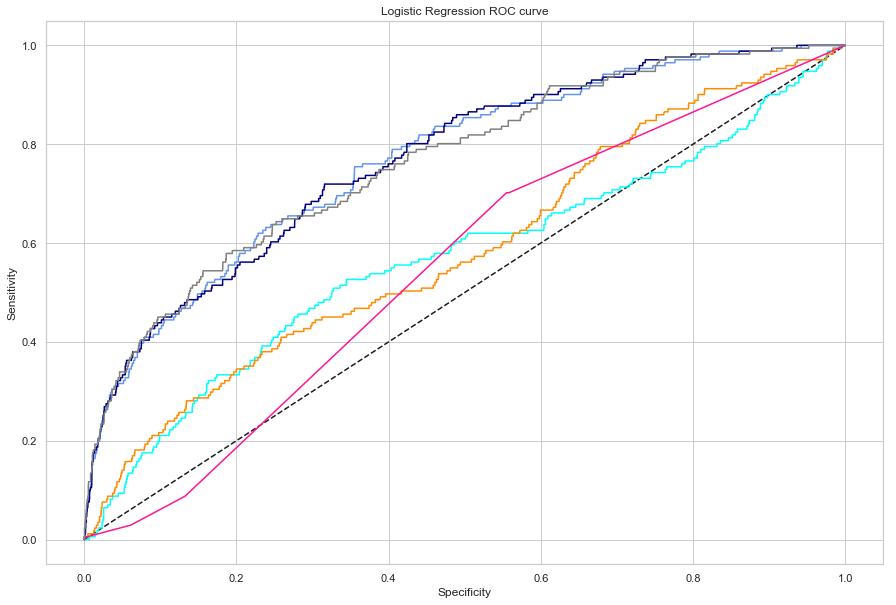

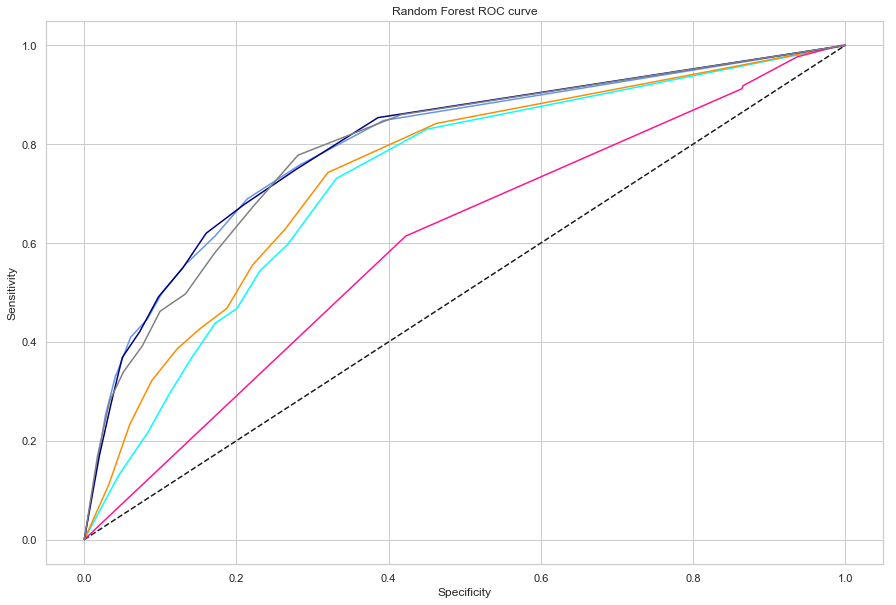

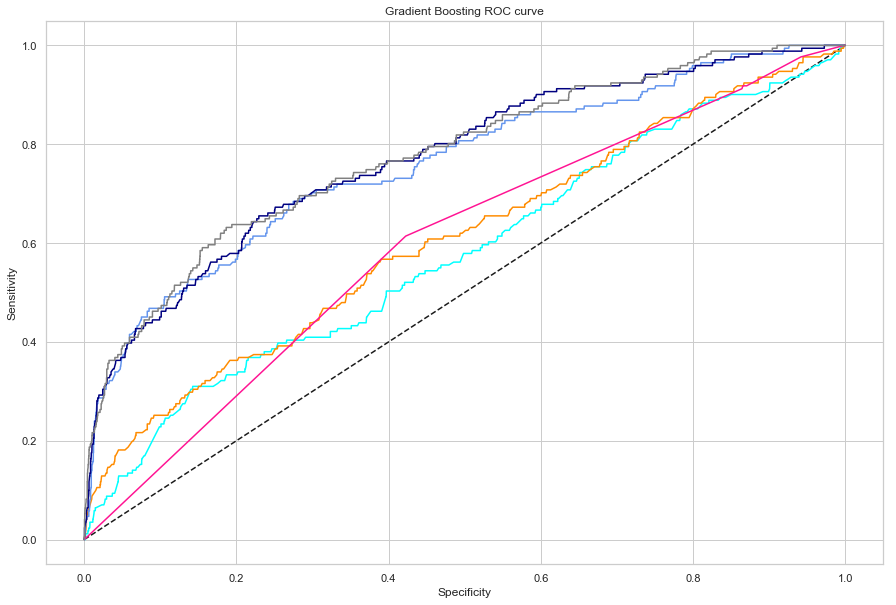

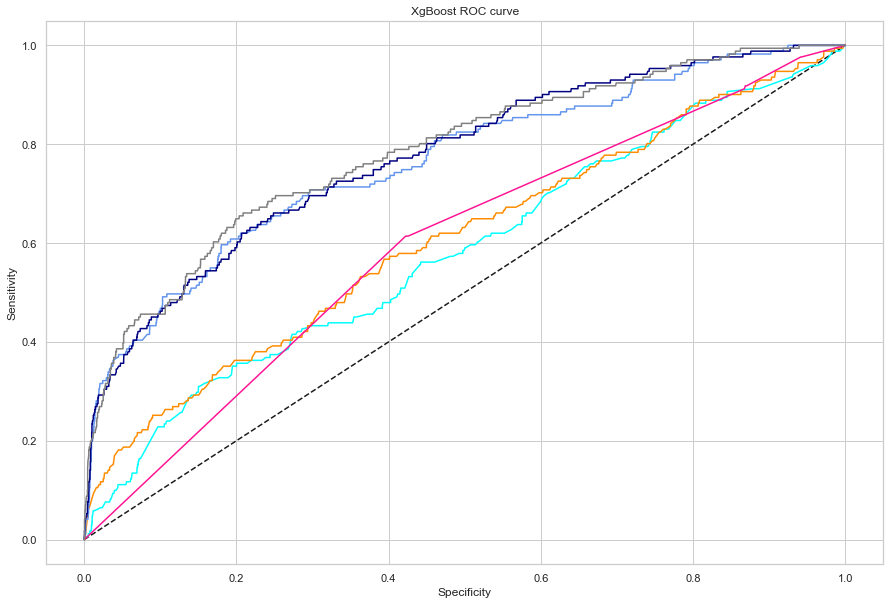

In [55]:
roc_plt(par_def_350, group_name)

#### Cibil more than 350

In [67]:
df_app_def_m_350 = df_app_def[df_app_def.lcibil > log(350+1)]
df_app_def_m_350.shape

(216986, 24)

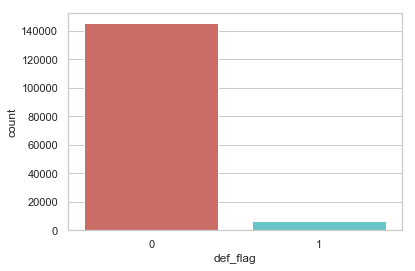

There are 151890 records in the dataset 
There are 6578 records make def_flag 1 in the dataset 
There are 145312 records make def_flag 0 in the dataset 




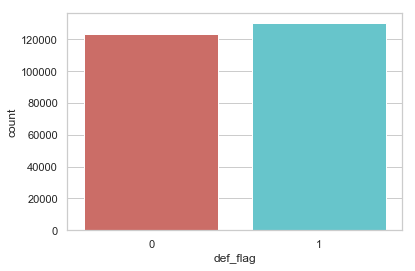

There are 253828 records in the dataset 
There are 130160 records make def_flag 1 in the dataset 
There are 123668 records make def_flag 0 in the dataset 


In [68]:
df_app_def_m_350_train, df_app_def_m_350_test  = train_test_split(df_app_def_m_350,test_size=0.3)
df_info(df_app_def_m_350_train,'def_flag')

df_app_def_train_m_350 = balancing(df_app_def_m_350_train.loc[:,features_all], 
                                   df_app_def_m_350_train.loc[:,'def_flag'],
                                   ['def_flag'])
df_info(df_app_def_train_m_350,'def_flag')

In [69]:
result_def_m_350 , par_def_m_350 = training(df_app_def_train_m_350,
                                            df_app_def_m_350_test,
                                            'def_flag',
                                            var_group,
                                            combine_var)

--------------------------
--------------------------
--------------------------
--------------------------


In [70]:
result_def_m_350.sort_values('test_auc',ascending = False)

,variable_model,cross_v_accuracy,test_accuracy,cross_v_auc,test_auc
11,"(RF, Digital + Cibil + Customer)",0.967135,0.881560,0.994835,0.708552
9,"(RF, Digital + Cibil)",0.957247,0.875461,0.992087,0.705434
7,"(RF, Customer + Cibil)",0.896032,0.857257,0.963219,0.689609
8,"(RF, Digital footprint)",0.961919,0.860268,0.993140,0.689410
6,"(RF, Customer characteristics)",0.906405,0.855183,0.964004,0.660757
5,"(LR_l2, Digital + Cibil + Customer)",0.599792,0.559574,0.643824,0.613613
23,"(XGB, Digital + Cibil + Customer)",0.720429,0.643020,0.802668,0.612988
3,"(LR_l2, Digital + Cibil)",0.594647,0.560403,0.638838,0.611249
20,"(XGB, Digital footprint)",0.659474,0.630008,0.730208,0.608561
17,"(GB, Digital + Cibil + Customer)",0.730601,0.653758,0.812859,0.607464


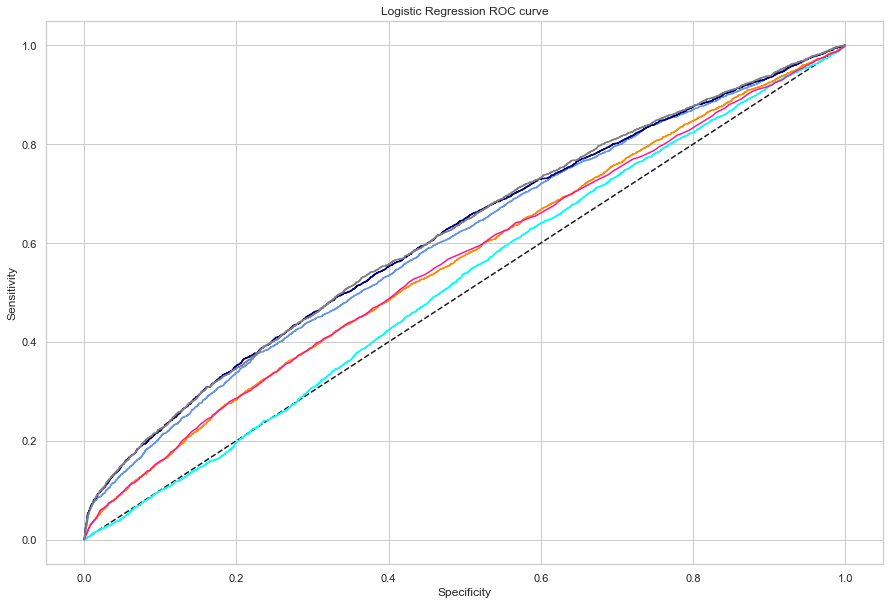

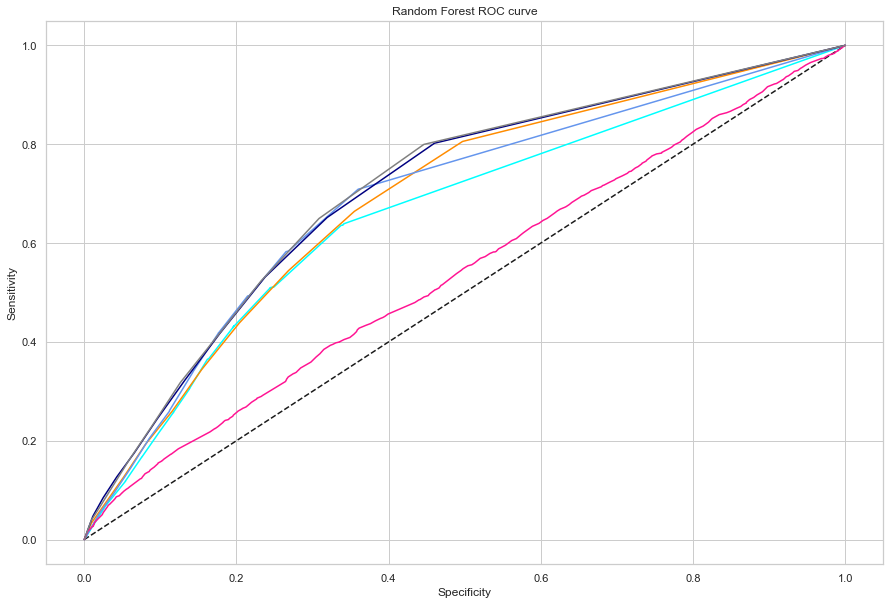

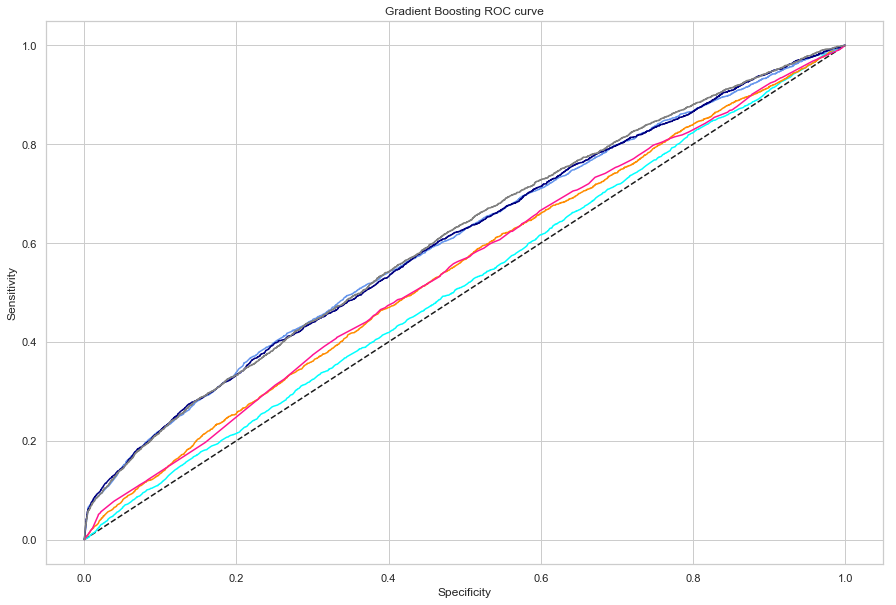

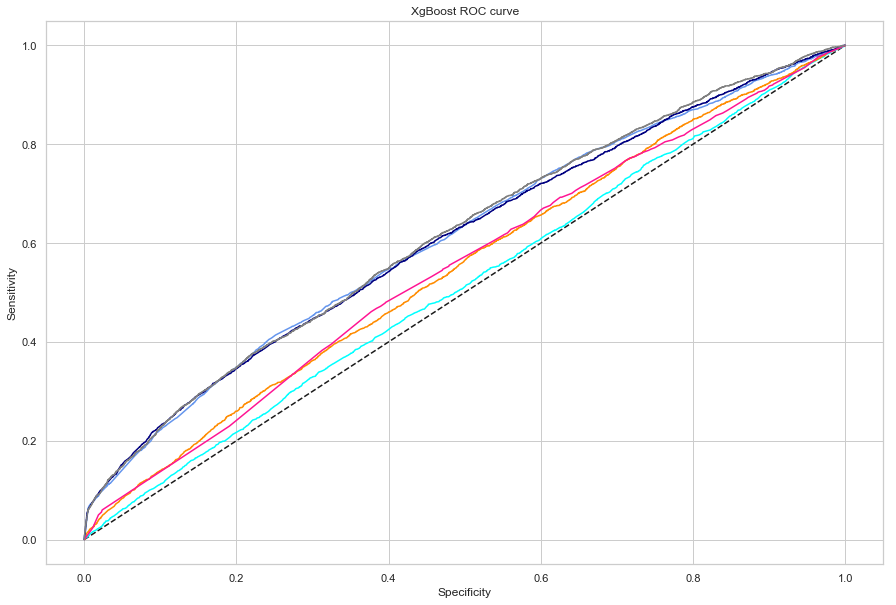

In [71]:
roc_plt(par_def_m_350, group_name)

#### Cibil more than median 350

In [73]:
median_score = df_app_def_m_350.lcibil.mean()
median_score

6.50654643095951

In [3]:
np.exp(6.50654643095951)

669.5102205500477

In [74]:
df_app_def_mid_350 = df_app_def[df_app_def.lcibil > median_score]
df_app_def_mid_350.shape

(126362, 24)

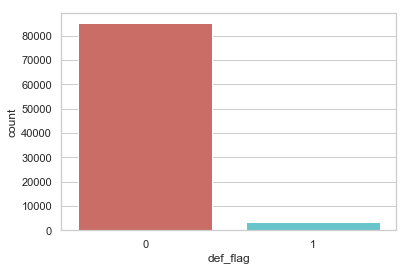

There are 88453 records in the dataset 
There are 3287 records make def_flag 1 in the dataset 
There are 85166 records make def_flag 0 in the dataset 




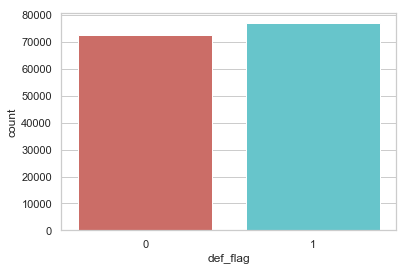

There are 149518 records in the dataset 
There are 77003 records make def_flag 1 in the dataset 
There are 72515 records make def_flag 0 in the dataset 


In [75]:
df_app_def_mid_350_train, df_app_def_mid_350_test  = train_test_split(df_app_def_mid_350,test_size=0.3)
df_info(df_app_def_mid_350_train,'def_flag')

df_app_def_train_mid_350 = balancing(df_app_def_mid_350_train.loc[:,features_all], 
                                   df_app_def_mid_350_train.loc[:,'def_flag'],
                                   ['def_flag'])
df_info(df_app_def_train_mid_350,'def_flag')

In [76]:
result_def_mid_350 , par_def_mid_350 = training(df_app_def_train_mid_350,
                                            df_app_def_mid_350_test,
                                            'def_flag',
                                            var_group,
                                            combine_var)

--------------------------
--------------------------
--------------------------
--------------------------


In [77]:
result_def_mid_350.sort_values('test_auc',ascending = False)

,variable_model,cross_v_accuracy,test_accuracy,cross_v_auc,test_auc
11,"(RF, Digital + Cibil + Customer)",0.970813,0.891846,0.995624,0.682473
9,"(RF, Digital + Cibil)",0.963249,0.889578,0.993518,0.681489
8,"(RF, Digital footprint)",0.962225,0.870638,0.992894,0.669548
7,"(RF, Customer + Cibil)",0.907837,0.872563,0.969678,0.665524
6,"(RF, Customer characteristics)",0.894956,0.850801,0.958646,0.660568
5,"(LR_l2, Digital + Cibil + Customer)",0.578251,0.501781,0.613768,0.577908
17,"(GB, Digital + Cibil + Customer)",0.765286,0.672795,0.849749,0.574046
23,"(XGB, Digital + Cibil + Customer)",0.760477,0.656836,0.844677,0.573065
3,"(LR_l2, Digital + Cibil)",0.571791,0.492179,0.607024,0.571225
2,"(LR_l2, Digital footprint)",0.570727,0.490279,0.606332,0.570220


In [110]:
result_def_mid_350.sort_values('variable_model',ascending = False)

,variable_model,cross_v_accuracy,test_accuracy,cross_v_auc,test_auc
20,"(XGB, Digital footprint)",0.691703,0.640191,0.772983,0.565728
23,"(XGB, Digital + Cibil + Customer)",0.760477,0.656836,0.844677,0.573065
21,"(XGB, Digital + Cibil)",0.750284,0.659131,0.837926,0.555701
18,"(XGB, Customer characteristics)",0.703634,0.545754,0.769474,0.522892
19,"(XGB, Customer + Cibil)",0.744024,0.632858,0.824530,0.520528
22,"(XGB, Cibil score)",0.723846,0.548313,0.803557,0.505845
8,"(RF, Digital footprint)",0.962225,0.870638,0.992894,0.669548
11,"(RF, Digital + Cibil + Customer)",0.970813,0.891846,0.995624,0.682473
9,"(RF, Digital + Cibil)",0.963249,0.889578,0.993518,0.681489
6,"(RF, Customer characteristics)",0.894956,0.850801,0.958646,0.660568


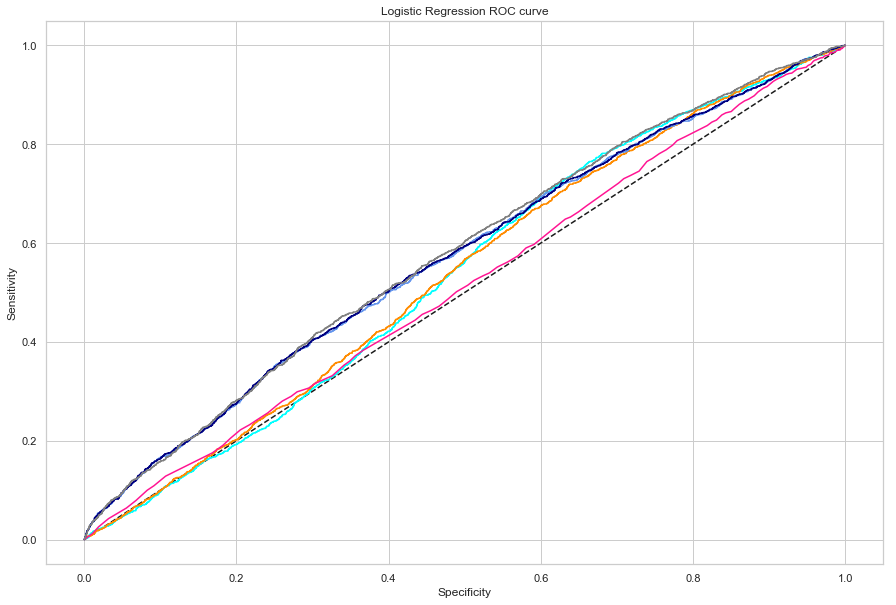

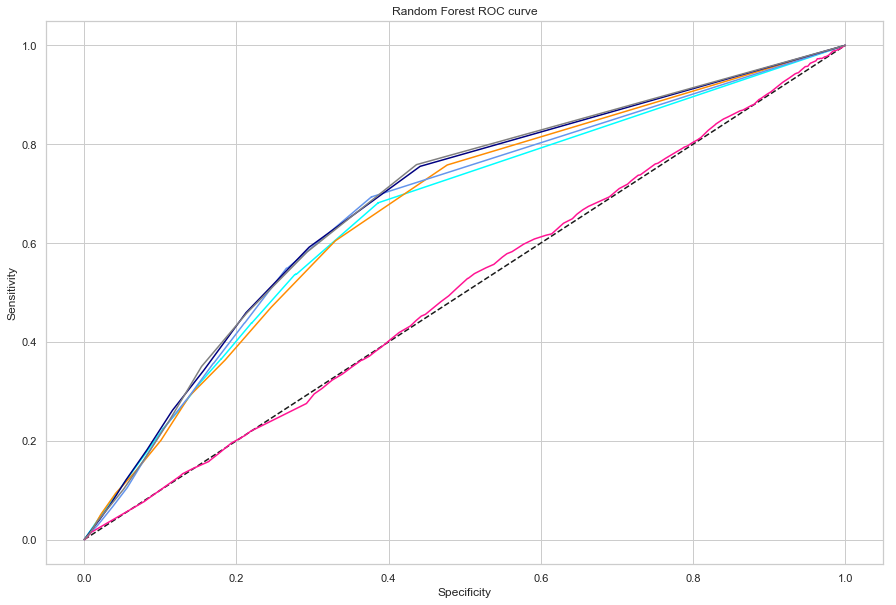

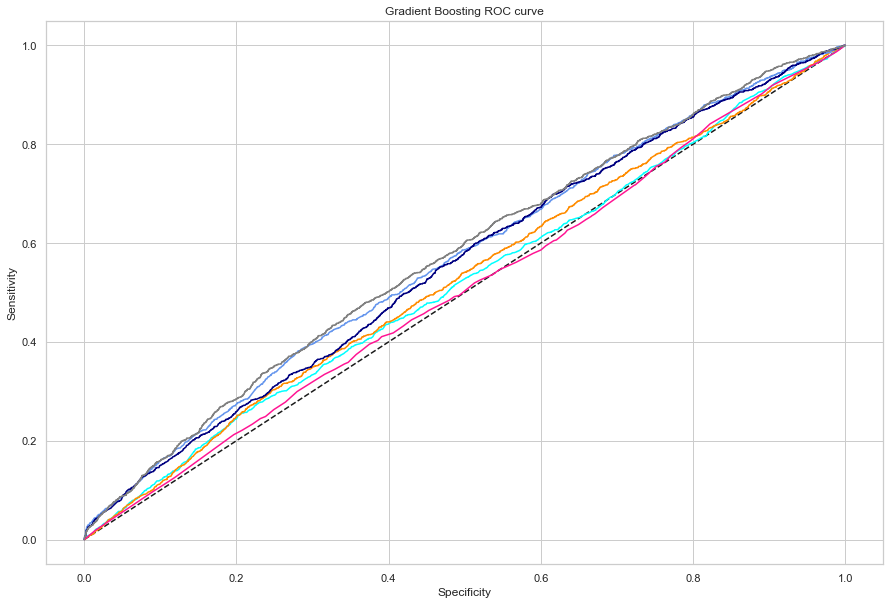

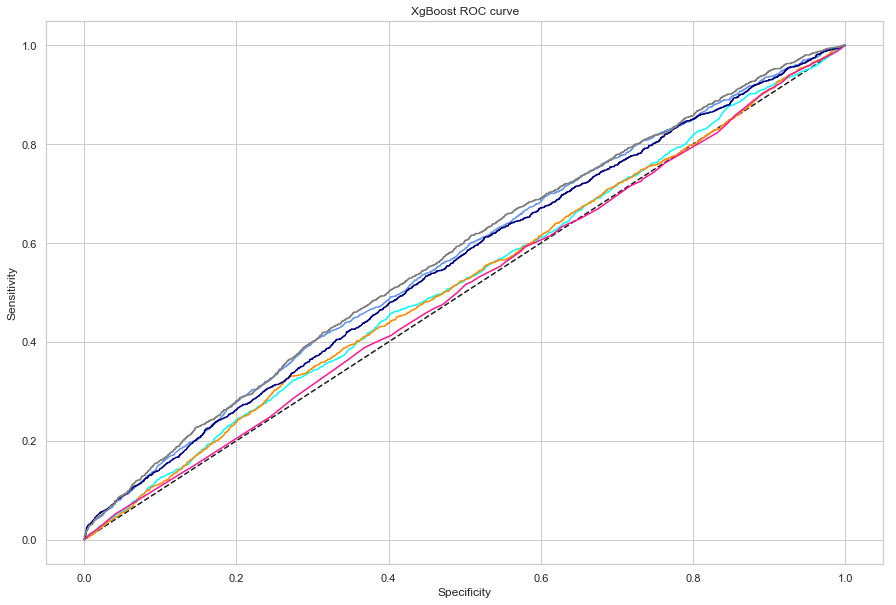

In [78]:
roc_plt(par_def_mid_350, group_name)

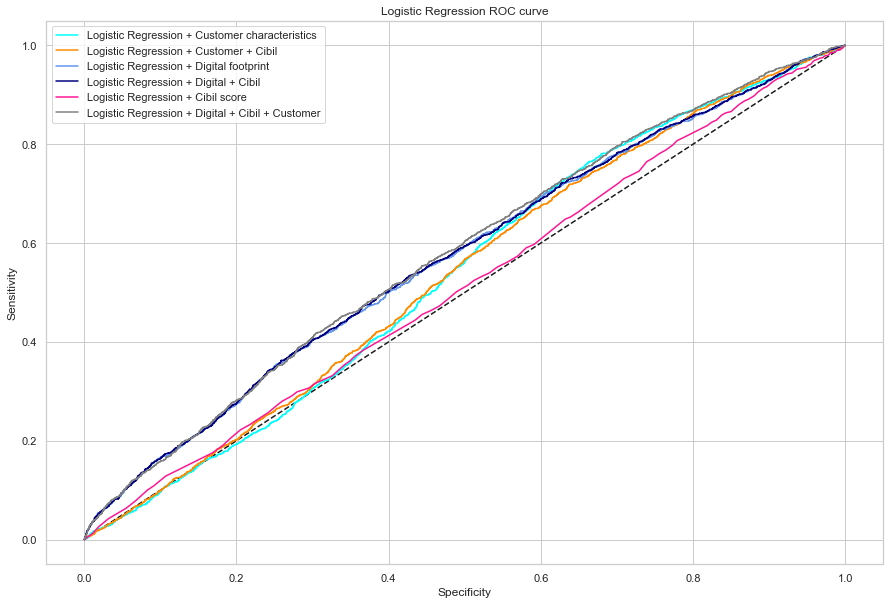

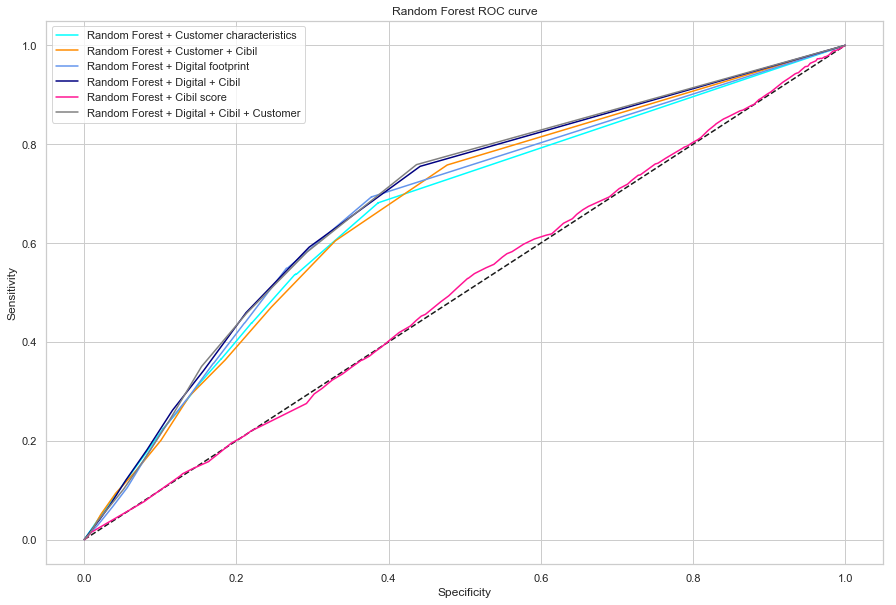

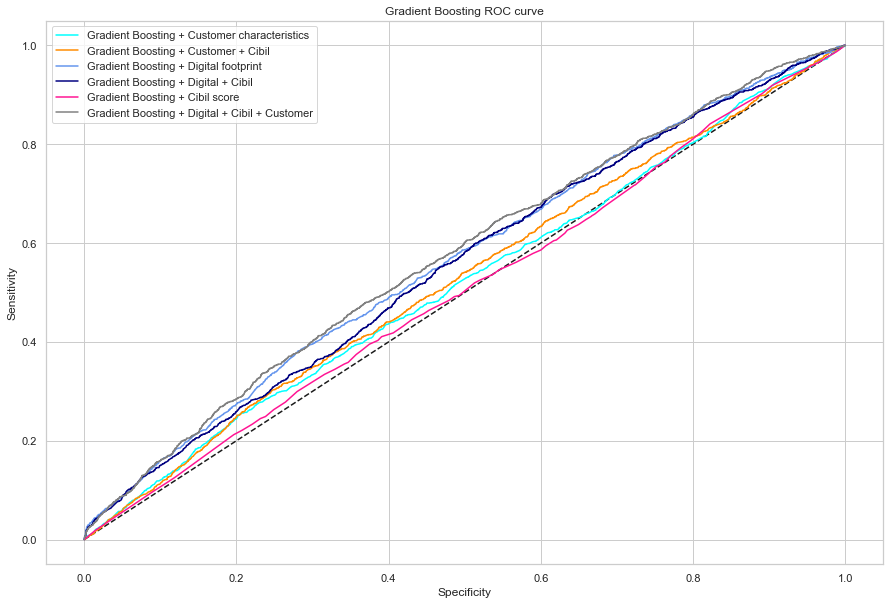

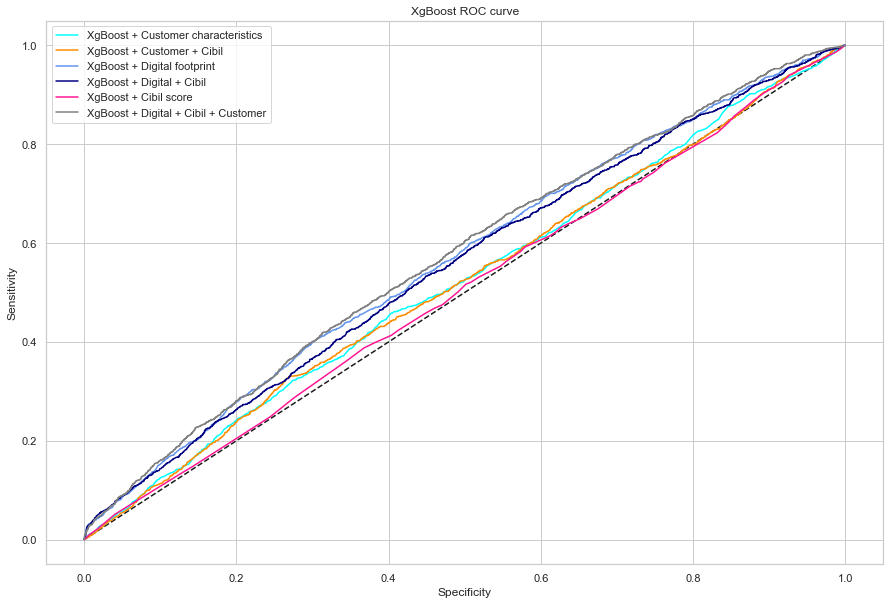

In [137]:
roc_plt(par_def_mid_350, group_name)

### feature selection

In [29]:
var_group = [Borrower_info,
             Digital_info,
             Cibil,
             Borrower_info + Cibil,
             Digital_info + Cibil,
             
            ]


In [53]:
prefix = ['(CI)','(DI)','(CIBIL)']

var_group_prefix = []

for i in range(3):
    var_group_prefix.append( [prefix[i] + v for v in var_group[i]])
    
var_group_prefix.append(var_group_prefix[0] + var_group_prefix[2])
var_group_prefix.append(var_group_prefix[1] + var_group_prefix[2])
var_group_prefix.append(var_group_prefix[2] + var_group_prefix[1] + var_group_prefix[0])

In [54]:
var_group_prefix

[['(CI)lage', '(CI)log_sal'],
 ['(DI)lsms',
  '(DI)lcallog',
  '(DI)lcontact',
  '(DI)facebook_status',
  '(DI)linkedin_status',
  '(DI)lapps',
  '(DI)ios'],
 ['(CIBIL)lcibil'],
 ['(CI)lage', '(CI)log_sal', '(CIBIL)lcibil'],
 ['(DI)lsms',
  '(DI)lcallog',
  '(DI)lcontact',
  '(DI)facebook_status',
  '(DI)linkedin_status',
  '(DI)lapps',
  '(DI)ios',
  '(CIBIL)lcibil'],
 ['(CIBIL)lcibil',
  '(DI)lsms',
  '(DI)lcallog',
  '(DI)lcontact',
  '(DI)facebook_status',
  '(DI)linkedin_status',
  '(DI)lapps',
  '(DI)ios',
  '(CI)lage',
  '(CI)log_sal']]

In [55]:
var_dictionary = dict(zip(var_group_prefix[-1], var_group[-1]))

In [56]:
import re
def clean_var(k):
    k= map(dict(zip(var_dictionary.values(), var_dictionary)).get, k)
    return [e.replace("_", " ") for e in list(k)]


def reverse_var(k):
    k = [e.replace(" ", "_") for e in k]
    
    k= map(var_dictionary.get, k)
    
    return list(k)

In [57]:
var_group_prefix_cleaned = [[x.replace('_',' ') for x in l] for l in var_group_prefix]

In [58]:
f_l11 = LogisticRegression(penalty= 'l1')
f_l11.fit(df_app_def_train.loc[:,features_all],df_app_def_train.loc[:,'def_flag'])
f_l1_sel = df_app_def_train.loc[:,features_all].columns[f_l11.coef_[0] != 0].tolist()  
f_l1_sel = clean_var(f_l1_sel)


In [59]:
rf = RandomForestClassifier()
   
rf.fit(df_app_def_train.loc[:,features_all],df_app_def_train.loc[:,'def_flag'])
    
r = df_app_def_train.loc[:,features_all].columns[rf.feature_importances_ != 0].tolist()
    
r = clean_var(r)


In [60]:
et = ExtraTreesClassifier()
    
et.fit(df_app_def_train.loc[:,features_all],df_app_def_train.loc[:,'def_flag'])
  
e = df_app_def_train.loc[:,features_all].columns[et.feature_importances_ != 0].tolist()

e = clean_var(e)


In [61]:
xgb = XGBClassifier()
    
xgb.fit(df_app_def_train.loc[:,features_all],df_app_def_train.loc[:,'def_flag'])
    
x = df_app_def_train.loc[:,features_all].columns[xgb.feature_importances_ != 0].tolist()
    
x = clean_var(x)

In [62]:
feature_Sel_df =pd.DataFrame()
feature_Sel_df['methods'] = ['Logistic_l1','ExtraTree','Xgboost','RandomForest'] 
feature_Sel_df['features_selected'] = [f_l1_sel,e,x,r]
feature_Sel_df['No_features_selected'] = feature_Sel_df['features_selected'].apply(lambda row: len(row))
feature_Sel_df['features_not_selected'] = feature_Sel_df['features_selected'].apply(lambda row: set(var_group_prefix_cleaned[-2]) - set(row))

In [63]:
df_feature_impor= pd.DataFrame()
df_feature_impor['importance'] =  [f_l11.coef_[0],et.feature_importances_,xgb.feature_importances_,rf.feature_importances_]
df_feature_impor['methods'] = ['Logistic_l1','ExtraTree','Xgboost','RandomForest'] 
df_feature_impor['Features'] = [var_group_prefix_cleaned[-2]]*4

s = df_feature_impor.apply(lambda x: pd.Series(x['importance']),axis=1).stack().reset_index(level=1, drop=True).reset_index(drop = True)
s.name = 'importance'
f = df_feature_impor.apply(lambda x: pd.Series(x['Features']),axis=1).stack().reset_index(level=1, drop=True).reset_index(drop = True)
f.name = 'Features'
m = pd.DataFrame(np.repeat(df_feature_impor.drop(['importance','Features'], axis=1).values,len(var_group[-2]),axis=0))
m.columns = ['methods']

In [64]:
f = f.astype(str).replace({  '(CI)lage' : '(CI)Log Age',
                                   '(CI)log sal' : '(CI)Log of Salary',
                                   '(DI)lsms' : '(DI)Log No. of SMS',
                                   '(DI)lcallog' : '(DI)Log Callog',
                                   '(DI)lcontact' : '(DI)Log No. of Contacts',
                                   '(DI)facebook status' : '(DI)Facebook status',
                                   '(DI)linkedin status' : '(DI)Linkedin status',
                                   '(DI)lapps' : '(DI)Log No. of Apps',
                                   '(DI)ios' : '(DI)IOS Dummy',
                                   '(CIBIL)lCIBIl' : '(CIBIL)Log of CIBIL',
                                  })


In [65]:
feature_pivot =pd.concat([m,f,s],axis = 1)
feature_pivot = pd.pivot_table(feature_pivot, values='importance', index='methods',columns='Features')
feature_pivot

Features,(CIBIL)lcibil,(DI)Facebook status,(DI)IOS Dummy,(DI)Linkedin status,(DI)Log Callog,(DI)Log No. of Apps,(DI)Log No. of Contacts,(DI)Log No. of SMS
methods,,,,,,,,
ExtraTree,0.128776,0.104485,0.002338,0.132933,-0.023630,0.011252,0.129487,0.203708
Logistic_l1,-0.536025,-0.018886,-0.893004,-0.192158,-0.199633,-0.303059,0.039954,-0.053620
RandomForest,0.094761,0.053205,0.149620,0.069440,0.121654,0.091164,0.093786,0.039174
Xgboost,0.054572,0.224478,0.061208,0.076241,0.135048,0.339556,0.129079,0.002123


In [67]:
feature_pivot.to_csv('large_feature_impo_factors.csv')

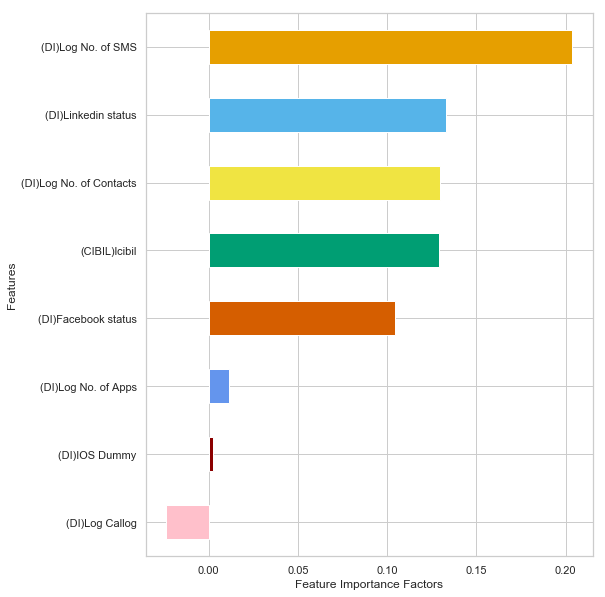

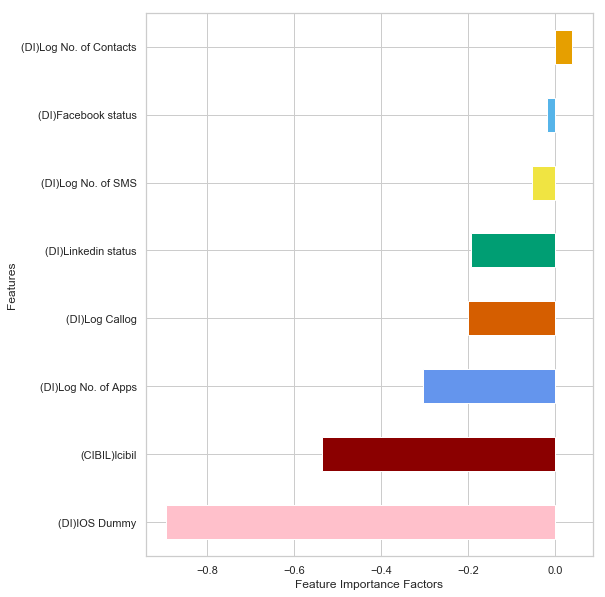

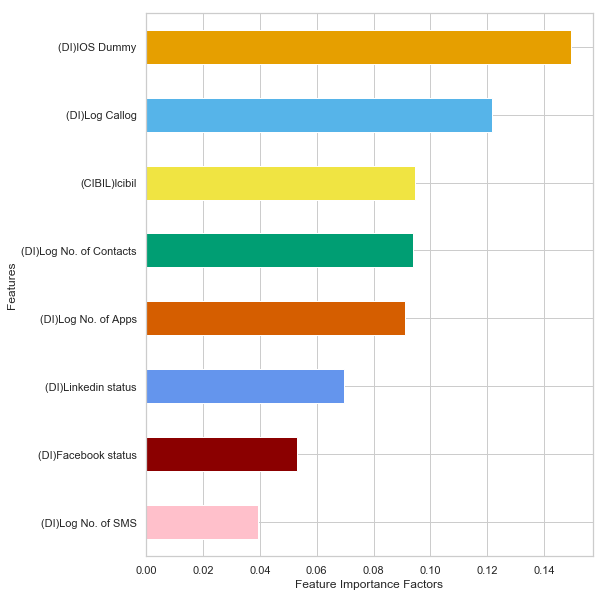

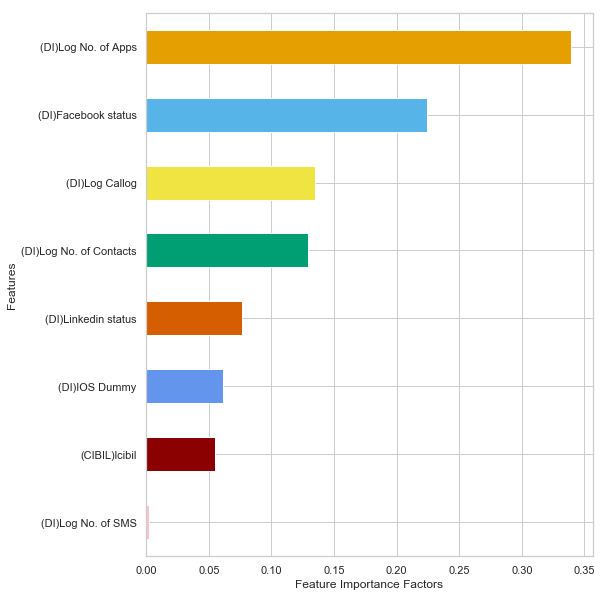

In [66]:
colors2  = ['#E69F00', '#56B4E9', '#F0E442', '#009E73', '#D55E00','cornflowerblue','darkred','pink','yellowgreen']

feature_pivot[feature_pivot != 0].iloc[0].dropna().nlargest(10).plot(kind='barh',colors = colors2,figsize=(8,10)).invert_yaxis()
plt.xlabel('Feature Importance Factors')
plt.show()
feature_pivot[feature_pivot != 0].iloc[1].dropna().nlargest(10).plot(kind='barh',colors = colors2,figsize=(8,10)).invert_yaxis()
plt.xlabel('Feature Importance Factors')
plt.show()
feature_pivot[feature_pivot != 0].iloc[2].dropna().nlargest(10).plot(kind='barh',colors = colors2,figsize=(8,10)).invert_yaxis()
plt.xlabel('Feature Importance Factors')
plt.show()
feature_pivot[feature_pivot != 0].iloc[3].dropna().nlargest(10).plot(kind='barh',colors = colors2,figsize=(8,10)).invert_yaxis()
plt.xlabel('Feature Importance Factors')
plt.show()

In [131]:
df_var_group = [var_group[-1],
                reverse_var(f_l1_sel),
                reverse_var(e),
                reverse_var(x),
                reverse_var(r)]

df_var_name = ['All features',
               'LogisticRegression selected',
               'ExtraTree selected',
               'Xgboost selected',
               'RandomForest selected'
         ]


combine_df_var = list(product(ml_labels,df_var_name))


In [132]:
result_df , par_df = training(df_app_def_train,
                              df_app_def_test,
                              'def_flag',
                              df_var_group,
                              combine_df_var)

--------------------------
--------------------------
--------------------------
--------------------------


In [ ]:
result_df.sort_values('test_auc',ascending = False)

In [ ]:
roc_plt(par_df, df_var_name)